In [13]:
import torch
import torch.nn as nn
import torch.optim as optim  # Import the optim module
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
import time  # Import the time module
import copy  # Import copy module for deep copying

# Define your data directory
data_dir = r'C:\Users\TAHMID HOSSAIN\Desktop\data'  # Set this to the path of your MRI dataset

# Define your data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}

# Create DataLoader for training and validation datasets
batch_size = 32  # Set your batch size
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Get the sizes of the datasets and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize the model
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(class_names)  # Update for your specific classes
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001  # Define your learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use the optimizer

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Define your learning rate scheduler

# Train model function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()  # Track time
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()  # Step the scheduler

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train and evaluate the model
num_epochs = 15  # Set the number of epochs you want to train for
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Save the best model
torch.save(model.state_dict(), 'best_mri_resnet101_model.pth')


Epoch 1/15
----------
train Loss: 0.5678 Acc: 0.7964
val Loss: 0.5050 Acc: 0.8131
Epoch 2/15
----------
train Loss: 0.2784 Acc: 0.9013
val Loss: 0.3563 Acc: 0.8658
Epoch 3/15
----------
train Loss: 0.2161 Acc: 0.9249
val Loss: 0.7035 Acc: 0.7506
Epoch 4/15
----------
train Loss: 0.1728 Acc: 0.9393
val Loss: 1.2593 Acc: 0.5393
Epoch 5/15
----------
train Loss: 0.1193 Acc: 0.9580
val Loss: 0.3331 Acc: 0.8802
Epoch 6/15
----------
train Loss: 0.1126 Acc: 0.9622
val Loss: 0.1769 Acc: 0.9413
Epoch 7/15
----------
train Loss: 0.0964 Acc: 0.9692
val Loss: 0.4876 Acc: 0.8513
Epoch 8/15
----------
train Loss: 0.0452 Acc: 0.9844
val Loss: 0.0521 Acc: 0.9802
Epoch 9/15
----------
train Loss: 0.0321 Acc: 0.9893
val Loss: 0.0345 Acc: 0.9886
Epoch 10/15
----------
train Loss: 0.0222 Acc: 0.9949
val Loss: 0.0352 Acc: 0.9886
Epoch 11/15
----------
train Loss: 0.0186 Acc: 0.9958
val Loss: 0.0302 Acc: 0.9901
Epoch 12/15
----------
train Loss: 0.0124 Acc: 0.9965
val Loss: 0.0217 Acc: 0.9908
Epoch 13/15
-

In [9]:
import torch
import torch.nn as nn  # Import nn here
from torchvision import models

# Define the number of classes
num_classes = 4  # Update this to match your dataset

# Load the model and redefine the last layer
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the best model weights
model.load_state_dict(torch.load('best_mri_resnet101_model.pth', map_location=device))

# Set model to evaluation mode
model.eval()



C:\Users\TAHMID HOSSAIN\AppData\Local\Temp\ipykernel_1756\208834579.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mri_resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Define your class names manually if you know them
class_names = ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']  # Replace with actual class names

# Now you can call the predict function
image_path = r'C:\Users\TAHMID HOSSAIN\Downloads\Programs\MRI-Brain-Images-abenign-bmalignant-images.png'  # Replace with your image path
predicted_class = predict(image_path, model, class_names)
print(f"Predicted Class: {predicted_class}")


Predicted Class: Meningioma


Confusion Matrix:
 [[294   5   0   1]
 [  0 305   1   0]
 [  0   0 405   0]
 [  0   1   0 299]]


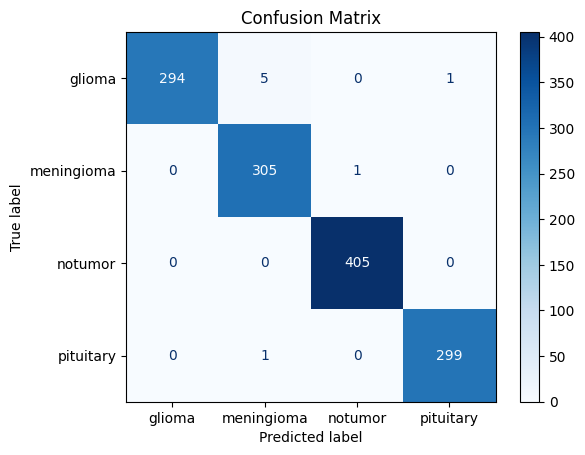

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [21]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Define your data directory
data_dir = r'C:\Users\TAHMID HOSSAIN\Desktop\data'  # Adjust the path to your dataset

# Define your data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}

# Create DataLoader for training and validation datasets
batch_size = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# If using the validation set as a test set
test_loader = dataloaders['val']

# Define the number of classes
num_classes = len(image_datasets['train'].classes)

# Load the model and redefine the last layer
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the best model weights with weights_only=True
model.load_state_dict(torch.load('best_mri_resnet101_model.pth', map_location=device, weights_only=True))

# Set model to evaluation mode
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_datasets['train'].classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Optionally, print a classification report
report = classification_report(all_labels, all_preds, target_names=image_datasets['train'].classes)
print("Classification Report:\n", report)
